<a href="https://colab.research.google.com/github/soyebganja/DL-Practice-Projects/blob/main/11%3AConvolutional%20Neural%20Networks%20(CNN)/11_4_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 47.0MB/s]


In [4]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [5]:
batch_size = 100

# Data Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


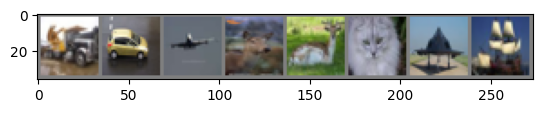

In [7]:
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# show images
# images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))

In [8]:
labels[:8]

tensor([9, 1, 0, 4, 4, 3, 0, 8])

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
[classes[i] for i in labels[:8]]

['truck', 'car', 'plane', 'deer', 'deer', 'cat', 'plane', 'ship']

In [11]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding="same"), # output (32, 32, 32)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # output (32, 16, 16)

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)), # output (64, 14, 14)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # output (64, 7, 7)
    )
    self.fc_layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=64*7*7, out_features=600),
      nn.ReLU(),
      nn.Linear(in_features=600, out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128, out_features=10)
    )

  def forward(self, x):
    x = self.network(x)
    x = self.fc_layers(x)
    return x

In [20]:
# Traininig Loop
def train_model(model_with_aug, train_loader_with_aug, num_epochs, optimizer, criterian):
  total_step = len(train_loader)
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterian(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')


  # Testing the modeltrain_loader_with_aug
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total} %')

In [12]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.001

model = ConvNet().to(device)
criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, train_loader, num_epochs, optimizer, criterian)

### With Data Augmentation

In [21]:
# import torch.vision.transform as transform
transform_with_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset_with_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_with_aug)
# test_dataset_with_aug = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_with_aug)
train_loader_with_aug = DataLoader(dataset=train_dataset_with_aug, batch_size=batch_size, shuffle=True)


model_with_aug = ConvNet().to(device)
criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_aug.parameters(), lr=learning_rate)

train_model(model_with_aug, train_loader_with_aug, num_epochs, optimizer, criterian)


Epoch [1/5], Step [100/500], Loss: 2.2978
Epoch [1/5], Step [200/500], Loss: 2.3066
Epoch [1/5], Step [300/500], Loss: 2.2901
Epoch [1/5], Step [400/500], Loss: 2.3120
Epoch [1/5], Step [500/500], Loss: 2.3111
Epoch [2/5], Step [100/500], Loss: 2.3039
Epoch [2/5], Step [200/500], Loss: 2.2944
Epoch [2/5], Step [300/500], Loss: 2.2970
Epoch [2/5], Step [400/500], Loss: 2.2906
Epoch [2/5], Step [500/500], Loss: 2.3136
Epoch [3/5], Step [100/500], Loss: 2.3023
Epoch [3/5], Step [200/500], Loss: 2.3054
Epoch [3/5], Step [300/500], Loss: 2.3089
Epoch [3/5], Step [400/500], Loss: 2.3178
Epoch [3/5], Step [500/500], Loss: 2.3156
Epoch [4/5], Step [100/500], Loss: 2.3063
Epoch [4/5], Step [200/500], Loss: 2.2982
Epoch [4/5], Step [300/500], Loss: 2.2950
Epoch [4/5], Step [400/500], Loss: 2.2979
Epoch [4/5], Step [500/500], Loss: 2.3019
Epoch [5/5], Step [100/500], Loss: 2.3015
Epoch [5/5], Step [200/500], Loss: 2.2993
Epoch [5/5], Step [300/500], Loss: 2.3110
Epoch [5/5], Step [400/500], Loss: